<a href="https://colab.research.google.com/github/saini-himanshu/emotion-ai/blob/main/FacialExpressionClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH =  "drive/MyDrive/Colab Notebooks/EmotionAI/"

In [ ]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv(PATH+'Dataset/facial_emotion_data.csv')

In [ ]:
data.head(1)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24568 entries, 0 to 24567
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  24568 non-null  int64 
 1    pixels  24568 non-null  object
dtypes: int64(1), object(1)
memory usage: 384.0+ KB


In [ ]:
emotions = data.iloc[:,0]
images = data.iloc[:,-1]

In [ ]:
emotions.shape

(24568,)

In [ ]:
images.shape

(24568,)

In [ ]:
images = images.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48, 48).astype('float32'))
images = images.apply(lambda x: cv2.resize(x, dsize=(96, 96), interpolation = cv2.INTER_CUBIC))

In [ ]:
images[0].shape

(96, 96)

In [ ]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

Some random Image visualizations

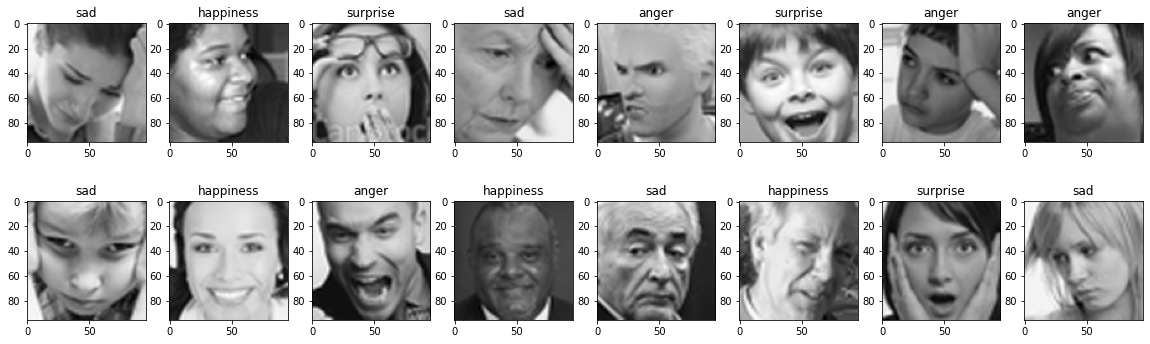

In [ ]:
fig = plt.figure(figsize=(20, 6))

for i in range(16):
    k = random.randint(1, len(images))
    ax = fig.add_subplot(2, 8, i + 1)    
    plt.imshow(images[k], cmap='gray')
    ax.set_title(label_to_text[emotions[k]])
    ax.axis('off')

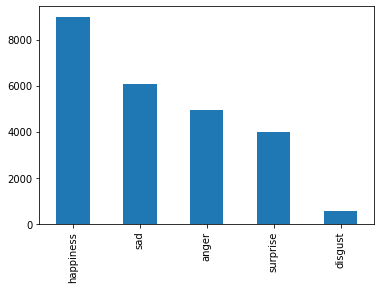

In [ ]:
emotions.map(label_to_text).value_counts().plot(kind='bar')

In [ ]:
from keras.utils import to_categorical

X = np.stack(images, axis = 0)
X = X.reshape(24568, 96, 96, 1)
X = X/255
y = to_categorical(emotions)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

base_model = ResNet50(include_top=False, weights=None, input_shape=(96,96,1))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(y.shape[1], activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam" , metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
checkpointer = ModelCheckpoint(filepath=PATH+"Emotions_weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_split = 0.2, callbacks=[checkpointer, earlystopping])

Epoch 1/30
553/553 [==============================] - 45s 62ms/step - loss: 2.0551 - accuracy: 0.3627 - val_loss: 1.7039 - val_accuracy: 0.3330

Epoch 00001: val_loss improved from inf to 1.70387, saving model to drive/MyDrive/Colab Notebooks/EmotionAI/Emotions_weights.hdf5
Epoch 2/30
553/553 [==============================] - 33s 60ms/step - loss: 1.0519 - accuracy: 0.5633 - val_loss: 1.3954 - val_accuracy: 0.4603

Epoch 00002: val_loss improved from 1.70387 to 1.39545, saving model to drive/MyDrive/Colab Notebooks/EmotionAI/Emotions_weights.hdf5
Epoch 3/30
553/553 [==============================] - 33s 61ms/step - loss: 0.8831 - accuracy: 0.6500 - val_loss: 1.0920 - val_accuracy: 0.5560

Epoch 00003: val_loss improved from 1.39545 to 1.09198, saving model to drive/MyDrive/Colab Notebooks/EmotionAI/Emotions_weights.hdf5
Epoch 4/30
553/553 [==============================] - 33s 61ms/step - loss: 0.8100 - accuracy: 0.6809 - val_loss: 1.0843 - val_accuracy: 0.5991

Epoch 00004: val_loss 

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open(PATH+"Emotions-model.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
from tensorflow.keras.models import model_from_json

with open(PATH+'Emotions-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model = model_from_json(json_savedModel)
model.load_weights(PATH+'Emotions_weights.hdf5')
model.compile(loss="categorical_crossentropy", optimizer="adam" , metrics=['accuracy'])

In [ ]:
# Evaluate the model

result = model.evaluate(X_Test, y_Test)
print("Accuracy : {}".format(result[1]))

39/39 [==============================] - 2s 22ms/step - loss: 0.7926 - accuracy: 0.7359
Accuracy : 0.7323026657104492


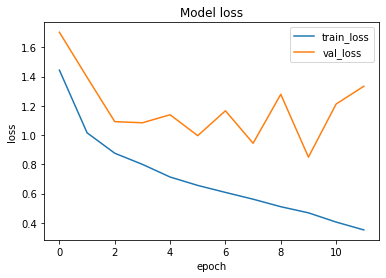

In [ ]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

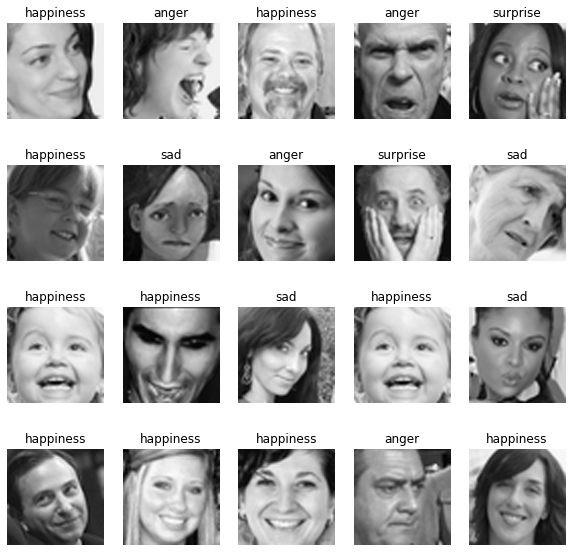

In [ ]:
y_true = np.argmax(y_Test, axis=-1)
predictions = np.argmax(model.predict(X_Test), axis=-1)

fig = plt.figure(figsize=(10, 10))

for i in range(20):
    k = random.randint(1, len(X_Test))
    ax = fig.add_subplot(4, 5, i + 1)    
    plt.imshow(X_Test[k].squeeze(), cmap='gray')
    ax.set_title(label_to_text[predictions[k]])
    ax.axis('off')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.vectorize(label_to_text.get)(y_true), np.vectorize(label_to_text.get)(predictions)))

              precision    recall  f1-score   support

       anger       0.56      0.59      0.57       230
     disgust       0.69      0.36      0.47        25
   happiness       0.84      0.82      0.83       455
         sad       0.66      0.68      0.67       314
    surprise       0.83      0.81      0.82       205

    accuracy                           0.73      1229
   macro avg       0.72      0.65      0.67      1229
weighted avg       0.74      0.73      0.73      1229

